<a href="https://colab.research.google.com/github/bhushanrajs/distribution_factors_pySR/blob/main/df_PySR_PSC_BM_G1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Installing Julia 1.8.5 on the current Colab Runtime...
2024-06-11 18:04:31 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz [130873886/130873886] -> "/tmp/julia.tar.gz" [1]
Installing PyCall.jl...
  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed VersionParsing ── v1.3.0
   Installed Parsers ───────── v2.8.1
   Installed PyCall ────────── v1.96.4
   Installed MacroTools ────── v0.5.13
   Installed JSON ──────────── v0.21.4
   Installed Conda ─────────── v1.10.0
   Installed Preferences ───── v1.4.3
   Installed PrecompileTools ─ v1.2.1
    Updating `~/.julia/environments/v1.8/Project.toml`
  [438e738f] + PyCall v1.96.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [8f4d0f93] + Conda v1.10.0
  [682c06a0] + JSON v0.21.4
  [1914dd2f] + MacroTools v0.5.13
  [69de0a69] + Parsers v2.8.1
  [aea7be01] + PrecompileTools v1.2.1
  [21216c6a] + P

Install PySR and PyTorch-Lightning:

In [2]:
%pip install -Uq pysr pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.4 MB/s eta 0:00:00


In [3]:
%pip install julia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.4 MB/s eta 0:00:00


In [4]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [ ]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Using Julia 1.8.5 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b"), Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()


In [1]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/distribution_factors_pySR/main/skew_0.csv')

In [3]:
print(df.head(5))

                             model girderName     L     D  w_oh    ts    S  \
0   Tx28-L_42-Nb_4-S_60-O_15-ts_85       Tx28  42.0  28.0   1.5   8.5  6.0   
1  Tx28-L_42-Nb_4-S_60-O_15-ts_100       Tx28  42.0  28.0   1.5  10.0  6.0   
2   Tx28-L_42-Nb_4-S_60-O_20-ts_85       Tx28  42.0  28.0   2.0   8.5  6.0   
3  Tx28-L_42-Nb_4-S_60-O_20-ts_100       Tx28  42.0  28.0   2.0  10.0  6.0   
4   Tx28-L_42-Nb_4-S_60-O_25-ts_85       Tx28  42.0  28.0   2.5   8.5  6.0   

    Nb     n_bm1     n_bm2  ...     n_bm4      n_r1      n_r2      n_r3  \
0  4.0  0.554060  0.293421  ...  0.000520  0.925505  0.086994  0.026596   
1  4.0  0.534037  0.298249  ...  0.000889  0.923853  0.093144  0.036185   
2  4.0  0.586017  0.279188  ...  0.000448  0.993568  0.023006  0.024837   
3  4.0  0.563802  0.286541  ...  0.000803  0.991692  0.031001  0.033527   
4  4.0  0.617704  0.265168  ...  0.000379  1.060984 -0.039607  0.022209   

       n_r4    sum_RY      d-G1      d-G2      d-G3          d-G4  
0 -0.039095 

In [41]:
L = df['L']
D = df['D']
S = df['S']
w_oh = df['w_oh']
ts = df['ts']
Nb = df['Nb']
LR = (w_oh/S + 1)
LD = L**2/D

n_bm1 = df['n_bm1']
n_bm2 = df['n_bm2']
n_r1 = df['n_r1']
n_r2 = df['n_r2']

In [5]:
# sample data from lever rule
# n_r1 = (w_oh + S) / S

In [42]:
X = np.stack((L, w_oh, S, D, LR, LD), axis=-1)
y = n_bm1

In [43]:
# Learn equations
default_pysr_params = dict(
    populations=50,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=100,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/', '^', "physics(x, y) = x^2 / y"],
    unary_operators=["square", "cube", "sqrt", "inv(x) = 1/x"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    constraints = {'^':(-1,1),'mult' : (3,3)},
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

model.fit(X, y)

print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:870: FutureWarning: loss has been renamed to elementwise_loss in PySRRegressor. Please use that instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


Streaming output truncated to the last 5000 lines.
                                  ^ 0.47595))
16          6.609e-04  1.435e-01  y = sqrt((x₄ + -0.6716) * (physics((inv(cube(0.25137)) / x₃) -...
                                   x₂, x₅) ^ 0.50542))
18          5.721e-04  7.222e-02  y = sqrt((-0.642 + x₄) * (physics(x₂ - (square(inv(sqrt(cube(0...
                                  .26079)))) / x₃), x₅) ^ 0.57355))
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.730e+04
Head worker occupation: 10.5%
Progress: 1000 / 5000 total iterations (20.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.724e-01  1.594e+01  y = 0.087659
2           1.612e-02  2.827e+00  y = sqrt(0.35268)
4           7.775e-03  3.644e-01  y = sqrt(0.0380

In [72]:
model.sympy(7)

0.571258029670247*(x1*x2**2/x5)**0.22266995

In [74]:
n_bm1_pred = model.predict(X,7)

print("Default selection MSE:", np.power(n_bm1_pred - y, 2).mean())

Default selection MSE: 0.0008964931565221568


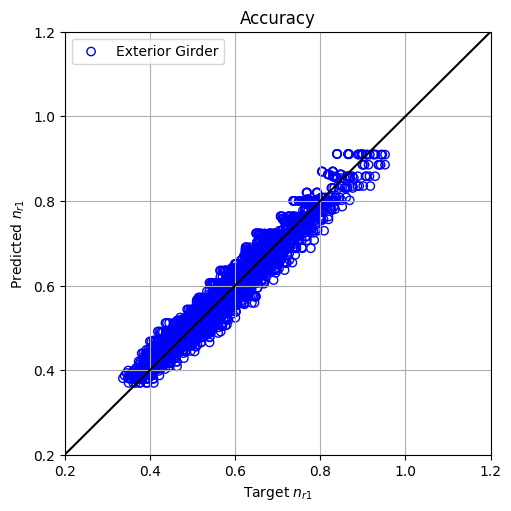

In [66]:
x_line = [0.2, 1.2]
y_line = [0.2, 1.2]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=n_bm1, y=n_bm1_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.2,1.2))
plt.ylim((0.2,1.2))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [ ]:
model.latex()

$0.757 + \frac{1}{\sqrt{\frac{x_{0}^{2}}{x_{1}^{2} x_{3}}}}$

$0.757 + \frac{w_{oh} D^{0.5}}{L}$

$\left(\frac{L^{2}}{w_{oh}^{2} {D} \sqrt{S}}\right)^{-0.290} + 0.575$